In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import (ZScaleInterval, ImageNormalize, LogStretch, 
            ManualInterval, SqrtStretch, AsymmetricPercentileInterval)
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from astropy.wcs import FITSFixedWarning
import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import eispac

In [2]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut.sort_values(by="date-obs")
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_green_df_ext = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,8))]
totality_green_df_ext.sort_values(by="date-obs")                                        
totality_green_df_ext = totality_green_df_ext.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut.sort_values(by="date-obs")
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

totality_red_df_ext = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,2))]
totality_red_df_ext.sort_values(by="date-obs")
totality_red_df_ext = totality_red_df_ext.reset_index(drop=True)

In [3]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [4]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

In [5]:
slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -27.5

eis_idl_sav = readsav("../../sav/EIS/EQSPY/EQSPY_lvl1_offset_170821_tilt_cor.sav",verbose=False)
eis_eqs_xcen, eis_eqs_ycen = np.array((eis_idl_sav["xcen"], eis_idl_sav["ycen_195"])) + eis_idl_sav["xy_correct_aia"]
eis_eqs_fovx, eis_eqs_fovy = np.array((eis_idl_sav["fovx"], eis_idl_sav["fovy"]))
eis_eqs_xstart = eis_eqs_xcen - eis_eqs_fovx/2.
eis_eqs_xend = eis_eqs_xcen + eis_eqs_fovx/2.
eis_eqs_ystart = eis_eqs_ycen - eis_eqs_fovy/2.
eis_eqs_yend = eis_eqs_ycen + eis_eqs_fovy/2.

In [6]:
eis_db_fe_10_184_fit_file = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5"
eis_db_fe_10_184_fit_res = eispac.read_fit(eis_db_fe_10_184_fit_file)

Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5


In [7]:
green_frame_wavelength = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_63.h5", 'r') as hf:
    green_fit_matrix_ext = hf['green_fit_matrix_ext'][:]
    green_fit_matrix_ext_err = hf['green_fit_matrix_ext_err'][:]
    green_fit_matrix_bin_ext = hf['green_fit_matrix_bin_ext'][:]
    green_fit_matrix_bin_ext_err = hf['green_fit_matrix_bin_ext_err'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]

In [8]:
green_limb_loc = np.array([396.,625.,])
x_1d_grid_green_ext = np.arange(-63,125,1,dtype=np.float64)
y_1d_grid_green_ext = np.arange(np.mean(green_limb_loc) - 699.,  np.mean(green_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_green_arcsec_ext = y_1d_grid_green_ext/(np.diff(green_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_green_arcsec_ext = x_1d_grid_green_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_green_arcsec_bin_ext = np.average(y_1d_grid_green_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_green_arcsec_ext, y_2d_grid_green_arcsec_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_ext)
x_2d_grid_green_arcsec_bin_ext, y_2d_grid_green_arcsec_bin_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_bin_ext)

y_green_step_correction_ext = (sun_y_fitpoly(np.linspace(0,93.5,188)) - sun_y_fitpoly(62))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_green_step_correction_ext = np.flip(y_green_step_correction_ext)

y_2d_grid_green_arcsec_correct_ext = y_2d_grid_green_arcsec_ext + y_green_step_correction_ext[np.newaxis,:]
y_2d_grid_green_arcsec_bin_correct_ext = y_2d_grid_green_arcsec_bin_ext + y_green_step_correction_ext[np.newaxis,:]

x_2d_grid_green_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

y_2d_grid_green_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

x_2d_grid_green_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

y_2d_grid_green_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

In [9]:
img_center = np.array([300,220])

def func_img_xpixel_to_xarcsec(x):
    return (x - img_center[0])/img_pixel_to_arcsec

def func_img_xarcsec_to_xpixel(x):
    return x*img_pixel_to_arcsec + img_center[0]

def func_img_ypixel_to_yarcsec(x):
    return (x - img_center[1])/img_pixel_to_arcsec

def func_img_yarcsec_to_ypixel(x):
    return x*img_pixel_to_arcsec + img_center[1]

def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [10]:
FeXIV_xslice = slice(345,395)
pixel_size_green = np.abs(np.mean(np.diff((green_frame_wavelength/63./10.)[FeXIV_xslice])))
inst_width_pix_green = 1.86
inst_width_nm_green = pixel_size_green*inst_width_pix_green

print(pixel_size_green, inst_width_nm_green)

0.024135148361387 0.04489137595217982


In [11]:
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

In [12]:
mask_bad_fit_matrix_ext = np.where(np.any(np.abs(green_fit_matrix_ext_err/green_fit_matrix_ext) > 0.5,axis=0) | \
                np.any(np.isnan(green_fit_matrix_ext_err),axis=0))
mask_bad_fit_matrix_bin_ext = np.where(np.any(np.abs(green_fit_matrix_bin_ext_err/green_fit_matrix_bin_ext) > 0.2,axis=0) | \
                np.any(np.isnan(green_fit_matrix_bin_ext_err),axis=0))

kernel = Gaussian2DKernel(x_stddev=1,y_stddev=2)
kernel_bin = Gaussian2DKernel(x_stddev=1,y_stddev=0.2)

green_where_disk_ext = np.where((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)**2 + \
                                    (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)**2 < 940**2)

green_line_int_masked = np.copy(green_fit_matrix_ext[1,:,:])
# green_line_int_masked[mask_bad_fit_matrix_ext] = np.nan
# green_line_int_masked = interpolate_replace_nans(green_line_int_masked,kernel)
green_line_int_masked[green_where_disk_ext] = np.nan

green_cont_masked = np.copy(green_fit_matrix_ext[3,:,:])
# green_cont_masked[mask_bad_fit_matrix_ext] = np.nan
# green_cont_masked = interpolate_replace_nans(green_cont_masked, kernel)
green_cont_masked[green_where_disk_ext] = np.nan

green_line_cont_ratio_masked = green_fit_matrix_ext[1,:,:]/green_fit_matrix_ext[3,:,:]
# green_line_cont_ratio_masked[mask_bad_fit_matrix_ext] = np.nan
# green_line_cont_ratio_masked = interpolate_replace_nans(green_line_cont_ratio_masked,kernel)
green_line_cont_ratio_masked[green_where_disk_ext] = np.nan

green_where_disk_bin_ext = np.where((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green)**2 + \
                                    (y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)**2 < 940**2)

green_vlos_masked = -(np.copy(green_fit_matrix_bin_ext[0,:,:]) - 530.29)/530.29*const.c.cgs.value*1e-5
green_vlos_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_vlos_masked[mask_bad_fit_matrix_bin_ext] = np.nan
green_vlos_masked[green_where_disk_bin_ext] = np.nan
green_vlos_masked = green_vlos_masked - np.nanmedian(green_vlos_masked)
# green_vlos_masked = interpolate_replace_nans(green_vlos_masked,kernel_bin)
green_vlos_masked[green_where_disk_bin_ext] = np.nan


green_fwhm_masked = np.copy(green_fit_matrix_bin_ext[2,:,:])
green_fwhm_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_fwhm_masked[mask_bad_fit_matrix_bin_ext] = np.nan
# green_fwhm_masked_err[green_where_disk_bin_ext] = np.nan        
green_veff_masked = np.sqrt(green_fwhm_masked**2 - inst_width_nm_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
# green_veff_masked = interpolate_replace_nans(green_veff_masked,kernel_bin)
green_veff_masked[green_where_disk_bin_ext] = np.nan

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
def find_nearest_pixel(x,y,x_grid,y_grid):
    distance = np.sqrt((x - x_grid)**2 + (y - y_grid)**2)
    index = np.unravel_index(np.argmin(distance),distance.shape)
    return index

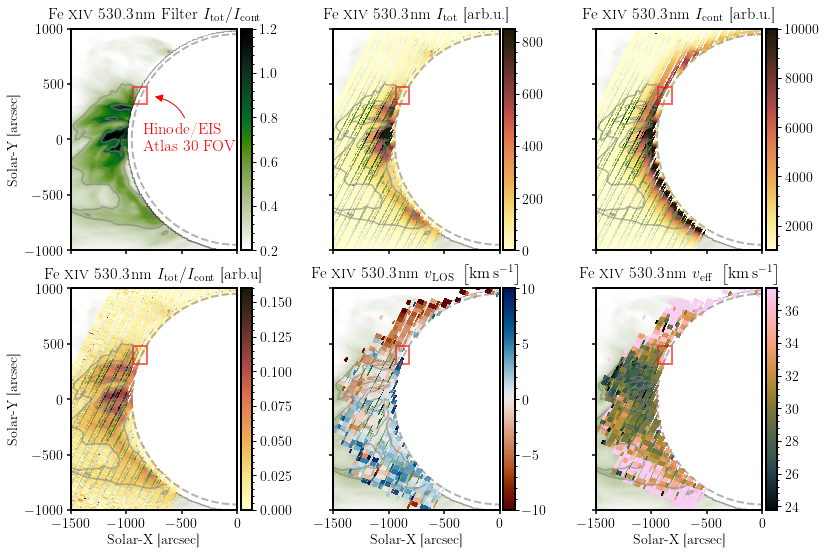

In [14]:
img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

colorbar_width = "7%"

def create_rec_eqs():
    return patches.Rectangle((eis_eqs_xstart, eis_eqs_ystart),
                            eis_eqs_fovx, eis_eqs_fovy,linewidth=2,edgecolor="red",
                            facecolor="none",alpha=0.6)

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(11.2,7.6),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="gouraud",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width)
ax1.annotate(r"Hinode/EIS" +"\n" + r"Atlas 30 FOV",(-760,390),(-850,-100),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=0.4","color":"red"},fontsize=16,color="red")

for ax_ in (ax2,ax3,ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="gouraud",rasterized=True,alpha=0.5)

im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_int_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=850,shading="auto")


plot_colorbar(im2, ax2,width=colorbar_width)

im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_cont_masked,cmap=cmcm.lajolla,rasterized=True,vmin=1000,vmax=10000)

plot_colorbar(im3, ax3,width=colorbar_width)

im4 = ax4.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.16)

plot_colorbar(im4, ax4,width=colorbar_width)

im5 = ax5.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width)

im6 = ax6.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_veff_masked,cmap=cmcm.batlowK,rasterized=True,
                vmin=0.07/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,vmax=0.11/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xiv} 530.3\,nm Filter $I_{\rm tot}/I_{\rm cont}$",fontsize=16,pad=10)
ax2.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16,pad=10)
ax3.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm cont}$ [arb.u.]",fontsize=16,pad=10)
ax4.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}/I_{\rm cont}$ [arb.u]",fontsize=16,pad=10)
ax5.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)
ax6.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)

xlim_zoomin = [-1500,0]
ylim_zoomin = [-1000,1000]


for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14,which="both",width=1.5)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)
fig.savefig(fname="../../figs/png/FeXIV_221130.png",dpi=300,format="png",bbox_inches="tight")

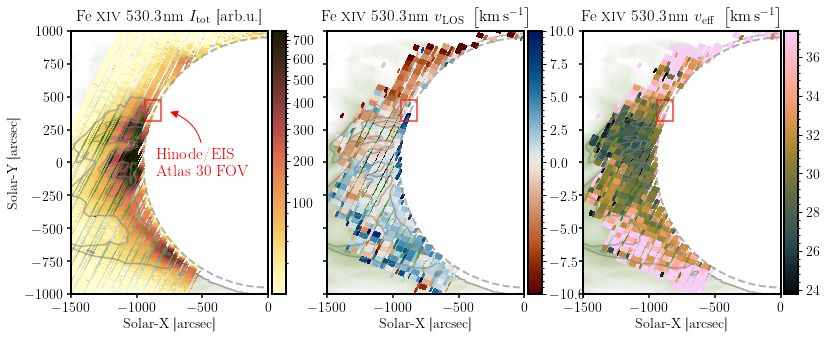

In [15]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(11.2,4.6),constrained_layout=True)

ax1.annotate(r"Hinode/EIS" +"\n" + r"Atlas 30 FOV",(-760,390),(-850,-100),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=0.4","color":"red"},fontsize=16,color="red")

for ax_ in (ax1,ax2,ax3):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="gouraud",rasterized=True,alpha=0.5)

norm_green_line_int = ImageNormalize(data=green_line_int_masked,interval=ManualInterval(10,750),stretch=SqrtStretch())
im1 = ax1.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_int_masked,cmap=cmcm.lajolla,rasterized=True,norm=norm_green_line_int,shading="auto")


plot_colorbar(im1, ax1,width=colorbar_width)

im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im2, ax2,width=colorbar_width)

im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_veff_masked,cmap=cmcm.batlowK,rasterized=True,
                vmin=0.07/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,vmax=0.11/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im3, ax3,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax1.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax2.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax3.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16,pad=10)
ax2.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)
ax3.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)

xlim_zoomin = [-1500,0]
ylim_zoomin = [-1000,1000]


for ax_ in (ax2,ax3):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14,which="both",width=1.5)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)
fig.savefig(fname="../../figs/png/FeXIV_comp_agu.png",dpi=300,format="png",bbox_inches="tight")

In [16]:
red_frame_wavelength = CCDData.read(os.path.join(red_path,totality_red_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data

with h5py.File("../../sav/Eclipse/FitResults/FeX_52.h5", 'r') as hf:
    red_fit_matrix_ext = hf['red_fit_matrix_ext'][:]
    red_fit_matrix_ext_err = hf['red_fit_matrix_ext_err'][:]
    red_fit_matrix_bin_ext = hf['red_fit_matrix_bin_ext'][:]
    red_fit_matrix_bin_ext_err = hf['red_fit_matrix_bin_ext_err'][:]
    red_fit_filename_index = hf['red_fit_filename_index'][:]
    red_fit_filename_index = hf['red_fit_filename_index'][:]

In [17]:
red_limb_loc = np.array([366.,592.,])
x_1d_grid_red_ext = np.arange(-51,125,1,dtype=np.float64) + 8
y_1d_grid_red_ext = np.arange(np.mean(red_limb_loc) - 699.,  np.mean(red_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_red_arcsec_ext = y_1d_grid_red_ext/(np.diff(red_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_red_arcsec_ext = x_1d_grid_red_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_red_arcsec_bin_ext = np.average(y_1d_grid_red_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_red_arcsec_ext, y_2d_grid_red_arcsec_ext = np.meshgrid(x_1d_grid_red_arcsec_ext, y_1d_grid_red_arcsec_ext)
x_2d_grid_red_arcsec_bin_ext, y_2d_grid_red_arcsec_bin_ext = np.meshgrid(x_1d_grid_red_arcsec_ext, y_1d_grid_red_arcsec_bin_ext)

y_red_step_correction_ext = (sun_y_fitpoly(np.linspace(0,87.5,176) - 4) - sun_y_fitpoly(66))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_red_step_correction_ext = np.flip(y_red_step_correction_ext)

y_2d_grid_red_arcsec_correct_ext = y_2d_grid_red_arcsec_ext + y_red_step_correction_ext[np.newaxis,:]
y_2d_grid_red_arcsec_bin_correct_ext = y_2d_grid_red_arcsec_bin_ext + y_red_step_correction_ext[np.newaxis,:]

x_2d_grid_red_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_correct_ext

y_2d_grid_red_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_correct_ext

x_2d_grid_red_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_bin_correct_ext

y_2d_grid_red_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_bin_correct_ext

In [18]:
FeX_xslice = slice(602,652)
pixel_size_red = np.abs(np.mean(np.diff((red_frame_wavelength/52/10.)[FeX_xslice])))
inst_width_pix_red = 2.12
inst_width_nm_red = pixel_size_red*inst_width_pix_red

img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXI_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXI_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

In [19]:
slit_xshift_red = sun_x_fitpoly(62) - slit_pos

slit_center_x_red =  - slit_xshift_red/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_red =  slit_xshift_red/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

In [20]:
red_mask_bad_fit_matrix_ext = np.where(np.any(np.abs(red_fit_matrix_ext_err/red_fit_matrix_ext) > 0.5,axis=0) | \
                np.any(np.isnan(red_fit_matrix_ext_err),axis=0))
red_mask_bad_fit_matrix_bin_ext = np.where(np.any(np.abs(red_fit_matrix_bin_ext_err/red_fit_matrix_bin_ext) > 0.2,axis=0) | \
                np.any(np.isnan(red_fit_matrix_bin_ext_err),axis=0))


red_where_disk_ext = np.where((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)**2 + \
                                    (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)**2 < 940**2)

red_line_int_masked = np.copy(red_fit_matrix_ext[1,:,:])
# red_line_int_masked[red_mask_bad_fit_matrix_ext] = np.nan
# red_line_int_masked = interpolate_replace_nans(red_line_int_masked,kernel)
red_line_int_masked[red_where_disk_ext] = np.nan

red_cont_masked = np.copy(red_fit_matrix_ext[3,:,:])
# red_cont_masked[red_mask_bad_fit_matrix_ext] = np.nan
# red_cont_masked = interpolate_replace_nans(red_cont_masked, kernel)
red_cont_masked[red_where_disk_ext] = np.nan

# red_line_cont_ratio_masked = red_fit_matrix_ext[1,:,:]/red_fit_matrix_ext[3,:,:]
# red_line_cont_ratio_masked[red_mask_bad_fit_matrix_ext] = np.nan
# red_line_cont_ratio_masked = interpolate_replace_nans(red_line_cont_ratio_masked,kernel)
# red_line_cont_ratio_masked[red_where_disk_ext] = np.nan
red_line_cont_ratio_masked = red_line_int_masked/red_cont_masked

red_where_disk_bin_ext = np.where((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2 < 940**2)

red_vlos_masked = -(np.copy(red_fit_matrix_bin_ext[0,:,:]) - 637.451)/637.451*const.c.cgs.value*1e-5
red_vlos_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
red_vlos_masked[red_mask_bad_fit_matrix_bin_ext] = np.nan
red_vlos_masked[red_where_disk_bin_ext] = np.nan
red_vlos_masked = red_vlos_masked - np.nanmedian(red_vlos_masked)
red_vlos_masked_err = red_fit_matrix_bin_ext_err[0,:,:]/637.451*const.c.cgs.value*1e-5
red_vlos_masked_err[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
red_vlos_masked_err[red_mask_bad_fit_matrix_bin_ext] = np.nan
red_vlos_masked_err[red_where_disk_bin_ext] = np.nan

red_fwhm_masked = np.copy(red_fit_matrix_bin_ext[2,:,:])
red_fwhm_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 1)] = np.nan
red_fwhm_masked[red_where_disk_bin_ext] = np.nan
red_fwhm_masked[red_mask_bad_fit_matrix_bin_ext] = np.nan
red_fwhm_masked_err = np.copy(red_fit_matrix_bin_ext_err[2,:,:])
red_fwhm_masked_err[np.where(red_fit_matrix_bin_ext[1,:,:] < 1)] = np.nan
red_fwhm_masked_err[red_mask_bad_fit_matrix_bin_ext] = np.nan
red_fwhm_masked_err[red_where_disk_bin_ext] = np.nan

red_veff_masked = np.sqrt(red_fwhm_masked**2 - inst_width_nm_red**2)/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
red_veff_masked_err = red_fwhm_masked/np.sqrt(red_fwhm_masked**2 - inst_width_nm_red**2)* \
    red_fwhm_masked_err/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt


In [21]:
def create_rec_db():
    eis_db_extent = eis_db_fe_10_184_fit_res.meta['extent_arcsec']
    xstart = eis_db_extent[0]
    fovx = np.diff(eis_db_extent[:2])
    ystart = eis_db_extent[2]
    fovy = np.diff(eis_db_extent[2:])
    return patches.Rectangle((xstart, ystart),
                            fovx, fovy,linewidth=2,edgecolor="red",
                            facecolor="none",alpha=0.6)

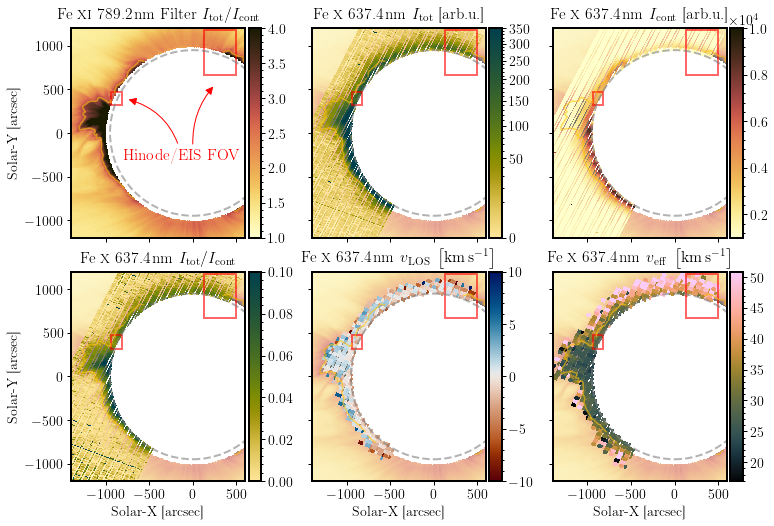

In [26]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(10.5,7.2),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                    cmap=cmcm.lajolla,shading="auto",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width)

for ax_ in (ax2,ax3,ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                        cmap=cmcm.lajolla,shading="auto",rasterized=True,alpha=0.6)

ax1.annotate(r"Hinode/EIS FOV",(-760,390),(-800,-300),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=0.3","color":"red"},fontsize=16,color="red")

ax1.annotate(r"",(250,550),(0,-150),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=-0.2","color":"red"},fontsize=16,color="red")

norm_red_line_int = ImageNormalize(red_line_int_masked,interval=ManualInterval(0,350),
                        stretch=SqrtStretch())

im2 = ax2.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_int_masked,cmap=cmcm.bamako_r,rasterized=True,norm=norm_red_line_int)


plot_colorbar(im2, ax2,width=colorbar_width)


im3 = ax3.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_cont_masked,cmap=cmcm.lajolla,rasterized=True,vmin=1000,vmax=10000)

im3_clb, im3_clbax = plot_colorbar(im3, ax3,width=colorbar_width)
im3_clbax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
im3_clbax.yaxis.get_offset_text().set_fontsize(14)
im3_clbax.yaxis.get_offset_text().set(va="bottom",ha="left")
im3_clbax.yaxis.get_offset_text().set_position((0,1.2))

im4 = ax4.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_cont_ratio_masked,cmap=cmcm.bamako_r,rasterized=True,vmin=0,vmax=0.1)

plot_colorbar(im4, ax4,width=colorbar_width)

im5 = ax5.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                red_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width)

im6 = ax6.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                red_veff_masked,cmap=cmcm.batlowK,rasterized=True,vmin=0.06/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)),
                vmax=0.18/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xi} 789.2\,nm Filter $I_{\rm tot}/I_{\rm cont}$",fontsize=16,pad=10)
ax2.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm tot}$ [arb.u.]",fontsize=16,pad=10)
ax3.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm cont}$ [arb.u.]",fontsize=16,pad=10)
ax4.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm tot}/I_{\rm cont}$",fontsize=16,pad=10)
ax5.set_title(r"Fe \textsc{x} 637.4\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)
ax6.set_title(r"Fe \textsc{x} 637.4\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)

xlim_zoomin = [-1400,600]
ylim_zoomin = [-1200,1200]

for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,levels=[3],alpha=0.6,
            colors=['#FFC408'])
    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_rec_db())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)
fig.savefig(fname="../../figs/png/FeX_230123.png",dpi=300,format="png",bbox_inches="tight")

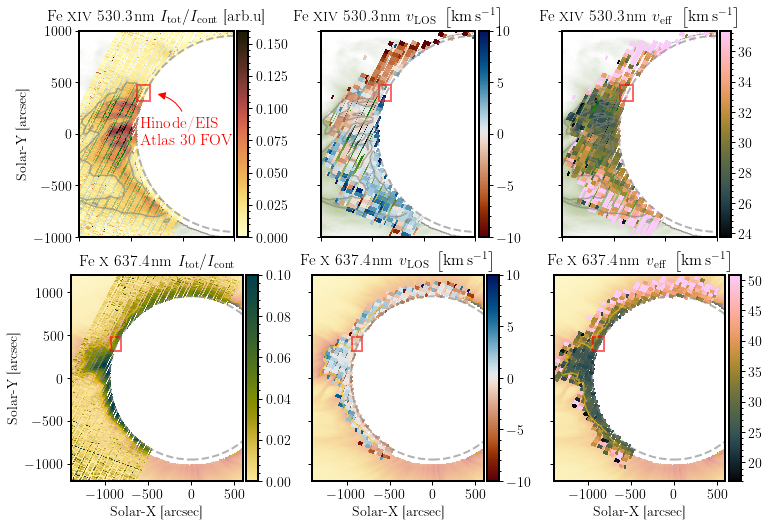

In [212]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(10.5,7.2),constrained_layout=True)

for ax_ in (ax1,ax2,ax3):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
                    cmap=cmr.jungle_r,shading="gouraud",rasterized=True,alpha=0.5)

im1 = ax1.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.16)

plot_colorbar(im1, ax1,width=colorbar_width)

im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im2, ax2,width=colorbar_width)

im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_veff_masked,cmap=cmcm.batlowK,rasterized=True,
                vmin=0.07/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,vmax=0.11/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im3, ax3,width=colorbar_width)


ax1.annotate(r"Hinode/EIS" +"\n" + r"Atlas 30 FOV",(-760,390),(-910,-100),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=0.4","color":"red"},fontsize=16,color="red")


for ax_ in (ax4,ax5,ax6):
    ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                        cmap=cmcm.lajolla,shading="auto",rasterized=True,alpha=0.6)

                        
im4 = ax4.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_cont_ratio_masked,cmap=cmcm.bamako_r,rasterized=True,vmin=0,vmax=0.1)

plot_colorbar(im4, ax4,width=colorbar_width)

im5 = ax5.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                red_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width)

im6 = ax6.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                red_veff_masked,cmap=cmcm.batlowK,rasterized=True,vmin=0.06/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)),
                vmax=0.18/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

plot_colorbar(im6, ax6,width=colorbar_width)

ax1.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax4.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax4.set_ylabel("Solar-Y [arcsec]",fontsize=14)
ax5.set_xlabel("Solar-X [arcsec]",fontsize=14)
ax6.set_xlabel("Solar-X [arcsec]",fontsize=14)

ax1.set_title(r"Fe \textsc{xiv} 530.3\,nm $I_{\rm tot}/I_{\rm cont}$ [arb.u]",fontsize=16,pad=10)
ax2.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)
ax3.set_title(r"Fe \textsc{xiv} 530.3\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)
ax4.set_title(r"Fe \textsc{x} 637.4\,nm $I_{\rm tot}/I_{\rm cont}$",fontsize=16,pad=10)
ax5.set_title(r"Fe \textsc{x} 637.4\,nm $v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)
ax6.set_title(r"Fe \textsc{x} 637.4\,nm $v_{\rm eff}\ \left[\mathrm{km\,s^{-1}}\right]$",fontsize=16,pad=10)

xlim_zoomin_green = [-1500,0]
ylim_zoomin_green = [-1000,1000]

xlim_zoomin_red = [-1400,600]
ylim_zoomin_red = [-1200,1200]

for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):

    ax_.add_patch(create_rec_eqs())
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
for ax_ in (ax1,ax2,ax3):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    ax_.set_xlim(xlim_zoomin_green)
    ax_.set_ylim(ylim_zoomin_green)   
for ax_ in (ax4,ax5,ax6):
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,levels=[3],alpha=0.6,
            colors=['#FFC408'])
    ax_.set_xlim(xlim_zoomin_red)
    ax_.set_ylim(ylim_zoomin_red)
fig.savefig(fname="../../figs/png/FeX_FeXIV_2017TSE.png",dpi=300,format="png",bbox_inches="tight")